In [1]:
import fiona
import shapely
from shapely.geometry import *
import pandas as pd
import geopandas as gpd
import numpy as np

import descartes
import shapely.ops as ops

import matplotlib.pyplot as plt
%matplotlib inline

/Users/Ben/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from math import radians, cos, sin, asin, sqrt

def haversine(p1, p2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    Points are ordered (lon, lat)
    """
    lon1, lat1 = p1[0], p1[1]
    lon2, lat2 = p2[0], p2[1]
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r


def to_xy(point):
    p = point.xy
    return (p[0][0], p[1][0])

def nearest_point(point, line):
    return line.interpolate(line.project(point))

In [3]:
home_sales = pd.read_csv("./major_road_data_science_challenge.csv")

Shape and geojson have coords flipped. Easier to flip the coordinates of the housing data points

In [4]:
lat_lon = zip(home_sales.GeoLat.tolist(), home_sales.GeoLon.tolist())
houses = [shapely.geometry.Point(lon, lat) for lat,lon in lat_lon]
home_sales["Point"] = houses

In [5]:
data_shp = gpd.read_file("./tl_2010_04_zcta510/tl_2010_04_zcta510.shp")

In [6]:
df_line = gpd.read_file("./phoenix_arizona.osm2pgsql-geojson/phoenix_arizona_osm_line.geojson")

### Find distances to different roads

#### Find distances to motorways

In [7]:
highway = df_line[df_line.highway == "motorway"].copy()

(32.5, 34.5)

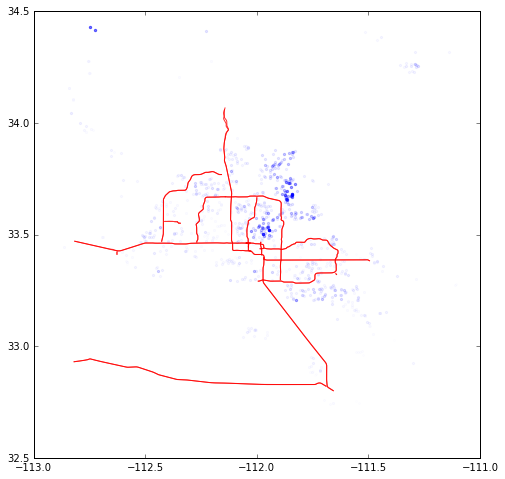

In [8]:
fig, ax = plt.subplots(figsize=(8,8))
gpd.GeoSeries(ops.linemerge(highway.geometry.values)).plot(alpha=0.8, ax=ax, color="red")

n=1000
alphas = home_sales.ClosePrice.values[:n]/np.sum(home_sales.ClosePrice.values[:n])
alphas = alphas/np.max(alphas)
for h,a in zip(houses[:n], alphas): 
    ax.scatter(*to_xy(h), alpha=a, s=5+a, color='blue')
ax.set_xlim(-113, -111)
ax.set_ylim(32.5, 34.5)

In [437]:
# fig, ax = plt.subplots()
# ax.scatter(*to_xy(houses[3]))
# p = nearest_point(houses[3], highways)
# plt.scatter(*to_xy(p))
# gpd.GeoSeries(highways).plot(ax=ax)

In [9]:
# compute distance to any highway

In [10]:
highway_geom = ops.linemerge(highway.geometry.values)
house_highway = [nearest_point(h, highway_geom) for h in houses]

In [11]:
hav_distances = [haversine(to_xy(h), to_xy(p)) for h,p in zip(houses, house_highway)]

In [12]:
home_sales["HaverSineDistance"] = hav_distances

### Model Fitting

In [13]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [16]:
max_distance = 20
mask = home_sales.HaverSineDistance < max_distance
data = home_sales[mask]

X, y = data[["HaverSineDistance"]], np.log(data.ClosePrice + 1)

In [18]:
deg = 3
ridge = make_pipeline(PolynomialFeatures(degree=deg), Ridge(fit_intercept=False))
ridge.fit(X,y)
print ridge.score(X,y)
print mean_squared_error(y.reshape(-1,1), ridge.predict(X).reshape(-1,1))

0.0182468522652
0.294787025938


In [19]:
deg = 5
model = make_pipeline(PolynomialFeatures(degree=deg), LinearRegression(fit_intercept=False))
model.fit(X, y)
print model.score(X,y)
print mean_squared_error(y.reshape(-1,1), model.predict(X).reshape(-1,1))

0.0236338642387
0.293169489755


In [426]:
from sklearn.svm import SVR
deg = 5
svr = SVR()
svr.fit(X, y)
r2_score(y.reshape(-1,1), svr.predict(X).reshape(-1,1))

0.016152279740520803

In [218]:
# fit a ridge regression to distance versus closing price

count    57788.000000
mean         7.346276
std         18.267433
min          0.002603
25%          1.493858
50%          3.006973
75%          5.518644
max        254.697617
Name: HaverSineDistance, dtype: float64

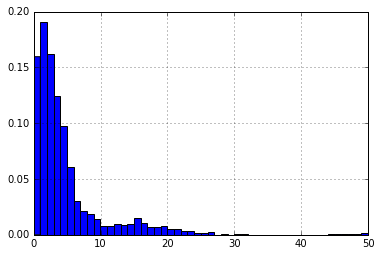

In [25]:
mask = home_sales.HaverSineDistance < 50
home_sales.HaverSineDistance[mask].hist(bins=50, normed=True)
home_sales.HaverSineDistance.describe()

In [27]:
# proportion that live less than 1 km away
(home_sales.HaverSineDistance <= 1).mean()

0.15506679587457603

In [29]:
# 85% of people live within 10km of highway
(home_sales.HaverSineDistance < 10).mean()

0.85552363812556242

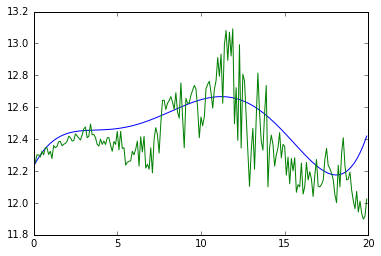

In [21]:
# grouping houses in bins of size dx
max_distance = 20
dx = 0.1
bins = np.arange(0,max_distance, dx)
prices_by_distance = [home_sales.loc[
        (home_sales.HaverSineDistance < d) & (home_sales.HaverSineDistance >= d - dx), 
        "ClosePrice"] for d in bins]

# x = np.array(bins)
# x_predict = svr.predict(x.reshape(-1,1))#np.poly1d(model.steps[-1][1].coef_[::-1])
# plt.plot(x, x_predict, color="red")


x = np.array(bins)
x_predict = model.predict(x.reshape(-1,1))#np.poly1d(model.steps[-1][1].coef_[::-1])
plt.plot(x, x_predict, color="blue")

plt.plot(bins, [np.log(p+1).median() for p in prices_by_distance], color='green')

### Distance from multiple highways

In [33]:
grouped_highways = highway.groupby("ref").apply(lambda x: ops.linemerge(x.geometry.values))

In [34]:
df = pd.DataFrame()
for key, value in grouped_highways.to_dict().items():
    df[key] = [h.distance(value) for h in houses]

In [35]:
df.head()

,US 60,AZ 101 Loop,AZ 303,AZ 24,I 10;US 60,I 8,I 17,Northern Parkway,AZ 202 Loop,AZ 202,AZ 51,I 17;US 60,AZ-101 Loop,I 10,AZ LOOP 202,AZ 303 Loop,AZ 143,AZ 85,AZ 202 Spur,I-17
0,0.483408,0.224352,0.698446,0.578686,0.478086,1.041334,0.301586,0.611043,0.394842,0.429851,0.257822,0.478819,0.477965,0.452882,0.586528,0.331171,0.427322,0.901429,0.450352,0.301436
1,0.207314,0.062779,0.606077,0.324018,0.234447,0.765332,0.287286,0.541386,0.126626,0.190383,0.180749,0.260053,0.416413,0.240909,0.327606,0.374063,0.200195,0.815747,0.211363,0.293217
2,0.123020,0.094093,0.443008,0.388176,0.103905,0.690228,0.130222,0.387770,0.061260,0.075161,0.061305,0.103905,0.276956,0.081114,0.222819,0.305324,0.053947,0.650621,0.082487,0.189377
3,0.273698,0.025197,0.580086,0.403149,0.270130,0.831441,0.242201,0.507028,0.199990,0.253687,0.128460,0.280727,0.375854,0.259430,0.375511,0.306965,0.223291,0.790465,0.243036,0.242053
4,0.327273,0.007912,0.192642,0.648840,0.258214,0.713303,0.131810,0.118848,0.227612,0.241266,0.208352,0.163167,0.045382,0.101844,0.374051,0.152241,0.284801,0.401837,0.292582,0.162332


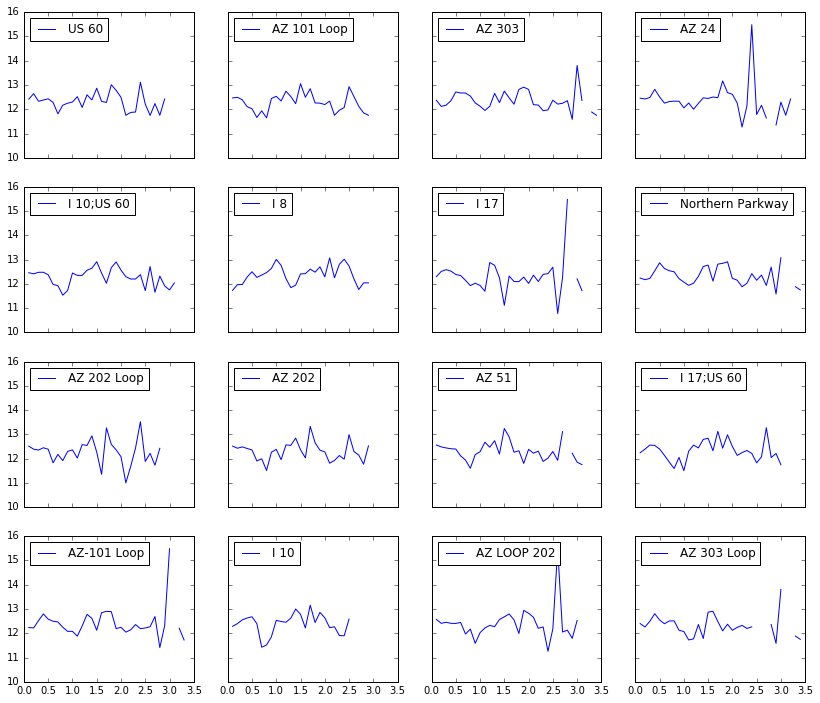

In [62]:
fig, ax = plt.subplots(figsize=(14,12), sharex=True, sharey=True, nrows=4, ncols=4)
max_distance = 10
dx = 0.1
bins = np.arange(0,max_distance, dx)

for a,col in zip(ax.ravel(), df.columns): 
    ls = []
    for d in bins:
        mask = (df[col] < d) & (df[col] >= d - dx)
        ls.append(np.log(home_sales.ClosePrice[mask]).mean())
    a.plot(bins, ls, label=col)
    a.legend(loc="upper left")

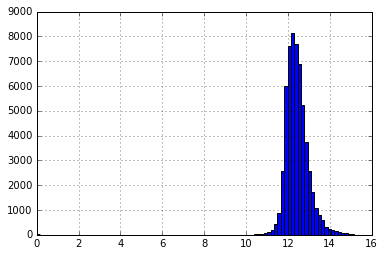

In [59]:
np.log(home_sales.ClosePrice).hist(bins=100)

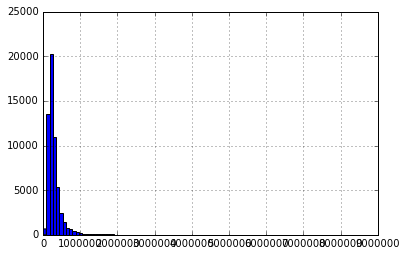

In [58]:
(home_sales.ClosePrice).hist(bins=100)

In [60]:
ridge = Ridge()
ridge.fit(df, np.log(home_sales.ClosePrice))

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='auto', tol=0.001)

In [61]:
ridge.score(df, np.log(1+home_sales.ClosePrice))

0.38878778678895676

### Primary or residential roads

In [55]:
residential = df_line[df_line.highway == "residential"]

In [217]:
df_line.name = df_line.name.fillna("Missing")
road_names = df_line[df_line.name.str.contains("North Cave Creek Road")]

In [362]:
residential.name.head()

13           Missing
14           Missing
18    Camelback Road
22           Missing
25           Missing
Name: name, dtype: object